ML4HC_Project01_Code:
Part 2


In [1]:
!pip install torchmetrics

In [2]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
import torchmetrics

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from skimage.io import imread, imshow
from skimage.measure import regionprops_table


In [3]:
#install kaggle
!pip install kaggle

In [4]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# make tmp kaggle folder, add json, allow
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/eth/kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
# download and unzip dataset
! kaggle datasets download paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [21]:
#load dataset paths
#have to store labels here..
data_dir = '/content/chest_xray/train/NORMAL/'
train_normal = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
train_normal = [data_dir + path for path in train_normal]
data_dir = '/content/chest_xray/train/PNEUMONIA/'
train_pneumonia = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
train_pneumonia = [data_dir + path for path in train_pneumonia]
train = train_normal + train_pneumonia

data_dir = '/content/chest_xray/val/NORMAL/'
val_normal = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
val_normal = [data_dir + path for path in val_normal]
data_dir = '/content/chest_xray/val/PNEUMONIA/'
val_pneumonia = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
val_pneumonia = [data_dir + path for path in val_pneumonia]
val = val_normal + val_pneumonia

data_dir = '/content/chest_xray/test/NORMAL/'
test_normal = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
test_normal = [data_dir + path for path in test_normal]
data_dir = '/content/chest_xray/test/PNEUMONIA/'
test_pneumonia = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.jpeg']
test_pneumonia = [data_dir + path for path in test_pneumonia]
test = test_normal + test_pneumonia

In [22]:
# to normalize to [0,1]
class normalize(object):
    def __call__(self, sample):
        sample = sample.float()
        sample = (sample - torch.min(sample)) / (torch.max(sample) - torch.min(sample))
        return sample

def get_data(path):
    # def transforms
    transform = transforms.Compose([
        transforms.Resize((512, 512)),  # resize
        transforms.ToTensor(),           # to PyTorch tensors, including normalization to [0, 1]
        normalize()                        # normalize to [0, 1]
    ])

    # load dataset with transforms
    dataset = datasets.ImageFolder(root=path, transform=transform)

    return dataset

In [23]:
# loading dataset
# train_dataset = get_data('/content/drive/MyDrive/ETH/MSc/chest_xray/train')
# val_dataset = get_data('/content/drive/MyDrive/ETH/chest_xray/val')
# test_dataset = get_data('/content/drive/MyDrive/ETH/chest_xray/test')

# mypath
train_dataset = get_data('/content/chest_xray/train')
val_dataset = get_data('/content/chest_xray/val')
test_dataset = get_data('/content/chest_xray/test')

#to dataloader
batch = 2

train = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
val = torch.utils.data.DataLoader(val_dataset, batch_size=batch, shuffle=True)
test = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=True)

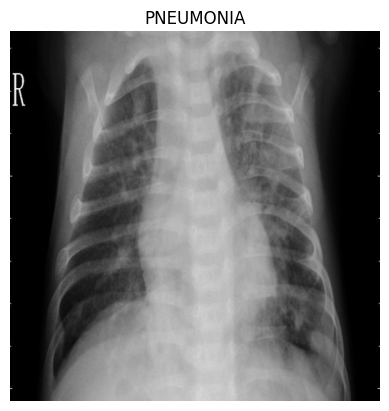

In [24]:
# Plot one example
# get next image
images, labels = next(iter(train))

# to numpy
image = images[0].numpy()
label = labels[0].item()

# convert tensor shape (channels, height, width) to (height, width, channels)
image = np.transpose(image, (1, 2, 0))

# def classes
classes = ['NORMAL', 'PNEUMONIA']

# plot
plt.imshow(image)
plt.title(classes[label])
plt.axis('off')
plt.show()

In [13]:
#images, labels = next(iter(train))
plt.imshow(images[5,0,:,:])

IndexError: index 5 is out of bounds for dimension 0 with size 2

In [ ]:
images[:,0,:,:].size()

In [ ]:
labels.size()

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.densenet121(pretrained=True)
        # for param in self.model.parameters():
        #     param.requires_grad = False
        ftrs = self.model.classifier.in_features
        self.model.classifier = nn.Linear(ftrs, 1) #final linear output layer
        self.model.classifier.trainable = True

    def forward(self, x):
        x = self.model(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
# load new saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
state_dict = torch.load('/content/drive/MyDrive/eth/ML4HC/trained_model_240416_200pix_10epochs.pth', map_location=device)
model.load_state_dict(state_dict)
model.to(device)

CNN(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affi

Grad-CAM

https://github.com/jacobgil/pytorch-grad-cam

In [16]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

torch.Size([2, 3, 512, 512])
(512, 512, 3)
(512, 512)


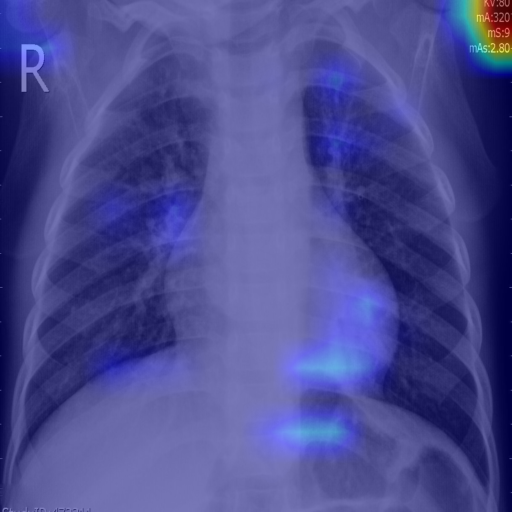

In [62]:
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM
import numpy as np
# class SigmoidOutputTarget:
#     def __init__(self, target):
#         self.target = target

#     def __call__(self, model_output):

#         target = (torch.sigmoid(model_output) > 0.5).int()
#         return torch.abs(target - self.target).float()

target_layers = [model.model.features[-1]]

cam = GradCAM(model=model.model, target_layers=target_layers)

# images, labels = next(iter(test))  # Assuming 'test' is your DataLoader
images, labels = next(iter(test))
images = images.to(device)


input_tensor = images
# input_tensor.requires_grad_ = True
print(input_tensor.shape)
grayscale_cam = cam(input_tensor=input_tensor, targets=[BinaryClassifierOutputTarget(0)])
# print(np.max(grayscale_cam))
# print(grayscale_cam)
# print(grayscale_cam.shape)
image = input_tensor[0].to("cpu").numpy().transpose([1, 2, 0])
grayscale_cam = grayscale_cam[0]
car_cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

